## Introduction

**Category Recommender example:**  
___
We want to answer the critcal question of:
<br>
<br>
**Am I making the best recommendations for the customer?**
<br>
<br>
In this example we will show how to:
- Setup the required environment for accessing the ecosystem prediction server.
- Upload data to ecosystem prediction server.
- Load data into feature store and parse to frame.
- Enrich feature store.
- Create category recommender model.
- View model performance.
- Write all predictions back to a dataset.

## Setup

**Setting up import path:**  
___
Add path of ecosystem notebook wrappers. It needs to point to the ecosystem notebook wrapper to allow access to the packages required for running the prediction server via python.
- **notebook_path:** Path to notebook repository. 

In [ ]:
notebook_path = "/path of to ecosystem notebook repository"

In [ ]:
# ---- Uneditible ----
import sys
sys.path.append(notebook_path)
# ---- Uneditible ----

**Import required packages:**  
___
Import and load all packages required for the following usecase.

In [5]:
# ---- Uneditible ----
import pymongo
from bson.son import SON
import pprint
import pandas as pd
import json
import numpy
import operator
import datetime
import time
import os
import matplotlib.pyplot as plt

from prediction import jwt_access
from prediction import notebook_functions
from prediction.apis import functions
from prediction.apis import data_munging_engine
from prediction.apis import data_management_engine
from prediction.apis import worker_h2o
from prediction.apis import prediction_engine
from prediction.apis import worker_file_service

%matplotlib inline
# ---- Uneditible ----

**Setup prediction server access:**  
___
Create access token for prediction server.
- **url:** Url for the prediction server to access.
- **username:** Username for prediction server.
- **password:** Password for prediction server.

In [2]:
url = "http://demo.ecosystem.ai:3001/api"
username = "user@ecosystem.ai"
password = "cd486be3-9955-4364-8ccc-a9ab3ffbc168"

In [3]:
# ---- Uneditible ----
auth = jwt_access.Authenticate(url, username, password)
# ---- Uneditible ----

Login Successful.


## Upload Data

**List uploaded files:**  
___
List all files already uploaded.

In [31]:
# ---- Uneditible ----
files = worker_file_service.get_files(auth, path="./", user=username)
files = files["item"]
for file in files:
    file_name = file["name"]
    fn_parts = file_name.split(".")
    if len(fn_parts) > 1 and fn_parts[-1] != "log":
        print(file_name)
# ---- Uneditible ----

get /getFiles?path=./&user=user@ecosystem.ai&
1718Pcard.csv
DR_Demo_LendingClub_Guardrails.csv
PCard Transactions 15-16.csv
amcd_test_data2.csv
amcs_test_data.csv
bank-full-1.csv
bank_customer.csv
bank_transactions-TIME-SERIES-7-DAY.csv
bank_transactions-TIMESERIES-590.csv
bank_transactions.csv
bank_transactions_SAMPLE.csv
bank_transactions_fs.csv
budget_messaging_featurestore.csv
combined-prediction-bank_full_1.hex
ecosystem.Ai Modules - 2021-04-07
fnbPrismFeatureStore20201.csv
graphing_states.csv
loan.csv
models.json
module_Corpora.jpeg
module_Corpus.001.png
module_churnIntervention.jpeg
module_nextPurchase.jpeg
module_offerRecommender.jpeg
occupation_variables_and_shock.csv
output.csv
patient_network_small.csv
prism_data.csv
profilesMaster.zip
properties.csv
query-impala-376379-non-null-0331.csv
query-impala-376379-non-null-0331_duration_format.csv
query-impala-376379-non-null-0331_sampler_actions_1-2.csv
query-impala-376379-non-null-0331_sampler_actions_1-2_duration.csv
query-impal

**List uploadable files:**  
___
List all files in path ready for upload to prediction server.

In [32]:
# ---- Uneditible ----
path = "../example_data/"
upload_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print(upload_files)
# ---- Uneditible ----

['output.csv']


**Upload file:**  
___
Select file to upload to prediction server.
- **file_name:** file name of file to upload to prediction server. See list of available files for upload.

In [34]:
file_name = "output.csv"

In [35]:
# ---- Uneditible ----
worker_file_service.upload_file(auth, path + file_name, "/data/")
# ---- Uneditible ----

post /upload


<Response [200]>

**List uploaded files:**  
___
List all files in path ready for upload to prediction server to compare with previous list to confirm that file was uploaded correctly.

In [7]:
# ---- Uneditible ----
files = worker_file_service.get_files(auth, path="./", user=username)
files = files["item"]
for file in files:
    file_name = file["name"]
    fn_parts = file_name.split(".")
    if len(fn_parts) > 1 and fn_parts[-1] != "log":
        print(file_name)
# ---- Uneditible ----

get /getFiles?path=./&user=user@ecosystem.ai&
1718Pcard.csv
DR_Demo_LendingClub_Guardrails.csv
PCard Transactions 15-16.csv
amcd_test_data2.csv
amcs_test_data.csv
bank-full-1.csv
bank_customer.csv
bank_transactions-TIME-SERIES-7-DAY.csv
bank_transactions-TIMESERIES-590.csv
bank_transactions.csv
bank_transactions_SAMPLE.csv
bank_transactions_fs.csv
budget_messaging_featurestore.csv
combined-prediction-bank_full_1.hex
ecosystem.Ai Modules - 2021-04-07
enriched_bank_transactions_10000.csv
fnbPrismFeatureStore20201.csv
graphing_states.csv
loan.csv
models.json
module_Corpora.jpeg
module_Corpus.001.png
module_churnIntervention.jpeg
module_nextPurchase.jpeg
module_offerRecommender.jpeg
multi_personality_tiny.csv
mutli_personality.csv
occupation_variables_and_shock.csv
output.csv
patient_network_small.csv
prism_data.csv
profilesMaster.zip
properties.csv
query-impala-376379-non-null-0331.csv
query-impala-376379-non-null-0331_duration_format.csv
query-impala-376379-non-null-0331_sampler_actions_

## Enrich Data

In [ ]:
database = "master"
collection = "bank_transactions"
attribute = "customer"
search = "{}"
mongodbf = "master"
collectionf = "bank_customer"
attributef = "customer"
fields = "education=education,gender=gender,language=language,numberOfProducts=numberOfProducts,changeIndicatorSix=changeIndicatorSix,changeIndicatorThree=changeIndicatorThree,numberOfChildren=numberOfChildren,numberOfAddresses=numberOfAddresses,segment_enum=segment_enum,region=region,maritalStatus=maritalStatus,age=age,proprtyOwnership=proprtyOwnership" 
data_munging_engine.foreign_key_lookup(auth, database, collection, attribute, search, mongodbf, collectionf, attributef, fields) 

In [6]:
filename = "enriched_bank_transactions_10000.csv"
filetype = "csv"
database = "master"
collection = "bank_transactions"
field = "{}"
sort = "{}"
projection = "{}"
limit = 10000
data_management_engine.export_documents(auth, filename, filetype, database, collection, field, sort, projection, limit)

get /exportMongoDocuments?file_name=enriched_bank_transactions_10000.csv&file_type=csv&database=master&collection=bank_transactions&field={}&sort={}&projection={}&limit=10000&


{'log': ['/data//bank_transactions-master-export--2021-07-29T10-33-05+0000.log'],
 'message': ['Processing'],
 'log_content': ['2021-07-29T10:33:05.603+0000\tconnected to: mongodb://127.0.0.1:54445/\n2021-07-29T10:33:06.610+0000\t[........................]  master.bank_transactions  0/10000  (0.0%)\n2021-07-29T10:33:07.317+0000\t[########################]  master.bank_transactions  10000/10000  (100.0%)\n2021-07-29T10:33:07.318+0000\texported 10000 records\n']}

## File to Featurestore

**Load file into feature store:**  
___
Load selected file into a feature store and parse the data into a frame.
- **file_name:** file name of uploaded file to load into a feature store.
- **featurestore_name:** name of feature store to load data into.

In [8]:
file_name = "enriched_bank_transactions_10000.csv"
featurestore_name = "category_recommender_bank_transactions"

In [9]:
# ---- Uneditible ----
hexframename, imp  = functions.save_file_as_userframe(auth, file_name, featurestore_name, username) 
df = pd.DataFrame(
    {
        "columns": imp["columnNames"],
        "column_types": imp["columnTypes"]
    }
)
df
# ---- Uneditible ----

get /processFileToFrameImport?file_name=enriched_bank_transactions_10000.csv&first_row_column_names=1&separator=,&
delete /deleteFrame?frame=enriched_bank_transactions_10000.hex&
post /saveUserFrame
post /processToFrameParse


,columns,column_types
0,account_type,Enum
1,effReformatted,Time
2,eff_date,Time
3,intl_ind,Numeric
4,trns_amt,Numeric
5,trns_type,Enum
6,effYearMonth,Time
7,MCC,Numeric
8,customer,Numeric
9,mcc_base_category,Enum


## Prepare Featurestore

In [10]:
# ---- Uneditible ----
frames = worker_h2o.prediction_frames(auth)
for frame in frames["frames"]:
    print(frame["frame_id"]["name"])
# ---- Uneditible ----    

get /predictionFrames
bank_customer.hex
bank_transactions.hex
enriched_bank_transactions_10000.hex


In [11]:
split_ratio = 0.20

In [12]:
# ---- Uneditible ----
worker_h2o.split_frame(auth, hexframename, split_ratio)
# ---- Uneditible ----

get /splitFrame?frame=enriched_bank_transactions_10000.hex&ratio=0.2&


{'__meta': {'schema_version': 3,
  'schema_name': 'RapidsNumberV3',
  'schema_type': 'Iced'},
 '_exclude_fields': '',
 'ast': None,
 'session_id': None,
 'id': None,
 'scalar': 1.0}

In [13]:
# ---- Uneditible ----
frames = worker_h2o.prediction_frames(auth)
for frame in frames["frames"]:
    print(frame["frame_id"]["name"])
# ---- Uneditible ----

get /predictionFrames
bank_customer.hex
bank_transactions.hex
enriched_bank_transactions_10000.hex
enriched_bank_transactions_100000_2.hex
enriched_bank_transactions_100000_8.hex


## Build Model

**Train Model:**
___
Set training parameters for model and train.
- **predict_id:** Id for the prediction (for logging). 
- **description:** Description of model (for logging).
- **model_id:** Id for the model (for logging).
- **model_type:** Type of model to build (for logging). 
- **frame_name:** Name of frame used (for logging).
- **frame_name_desc:** Description of frame used (for logging).
- **model_purpose:** Purpose of model (for logging).
- **version:** Model version (for logging).

The following parameters are dependend on what is selected in the algo parameter.

- **algo:** Algorithm to use to train model. (Availble algorithms: "H20-AUTOML")
- **training_frame:** Data frame to use for training the model.
- **validation_frame:** Data frame to use for validating the model.
- **max_models:** Maximum number of models to build.
- **stopping_tolerance:** (TODO)
- **max_runtime_secs:** Maximum number of seconds to spend on training.
- **stopping_rounds:** (TODO)
- **stopping_metric:** (TODO)
- **nfolds:** (TODO)
- **response_column:** The column or field in the dataset to predict.
- **ignored_columns:** List of columns to exclude in the model training.
- **hidden:** (TODO)
- **exclude_algos:** Algorithms to exclude in the automl run.

In [29]:
version = "0001"
model_id = featurestore_name + version
model_purpose = "Prediction of customer spend category for recommendation."
description = "Automated features store generated for " + featurestore_name
model_params = { 
        "predict_id": featurestore_name,
        "description": description,
        "model_id": model_id,
        "model_type": "AUTOML",
        "frame_name": hexframename,
        "frame_name_desc": description,
        "model_purpose": model_purpose,
        "version": version,
        "model_parms": {
            "algo": "H2O-AUTOML",
            "training_frame": "enriched_bank_transactions_100000_8.hex",
            "validation_frame": "enriched_bank_transactions_100000_2.hex",
            "max_models": 10,
            "stopping_tolerance": 0.005,
            "note_stop": "stopping_tolerance of 0.001 for 1m rows and 0.004 for 100k rows",
            "max_runtime_secs": 3600,
            "stopping_rounds": 10,
            "sort_metric": "logloss",
            "stopping_metric": "AUTO",
            "nfolds": 0,
            "note_folds": "nfolds=0 will disable the stacked ensemble creation process",
            "response_column": "mcc_base_category",
            "ignored_columns": [            
            ],
            "hidden": [
                "1"
            ],
            "exclude_algos": [
                "StackedEnsemble",
            ]
        }
    }

In [25]:
# ---- Uneditible ----
worker_h2o.train_model(auth, model_id, "automl", json.dumps(model_params["model_parms"]))
# ---- Uneditible ----

get /buildModel?model_id=category_recommender_bank_transactions1010&model_type=automl&model_parms={"algo": "H2O-AUTOML", "training_frame": "enriched_bank_transactions_100000_8.hex", "validation_frame": "enriched_bank_transactions_100000_2.hex", "max_models": 10, "stopping_tolerance": 0.005, "note_stop": "stopping_tolerance of 0.001 for 1m rows and 0.004 for 100k rows", "max_runtime_secs": 3600, "stopping_rounds": 10, "sort_metric": "logloss", "stopping_metric": "AUTO", "nfolds": 0, "note_folds": "nfolds=0 will disable the stacked ensemble creation process", "response_column": "mcc_base_category", "ignored_columns": [], "hidden": ["1"], "exclude_algos": ["StackedEnsemble"]}&


<Response [200]>

**Compare Models:**
___
View autoML model to see which generated models are performing the best.

In [34]:
# ---- Uneditible ----
model_data = worker_h2o.get_train_model(auth, model_id, "AUTOML")
notebook_functions.RenderJSON(model_data)
# ---- Uneditible ----

get /getAutoMLmodel?model_id=category_recommender_bank_transactions0001&


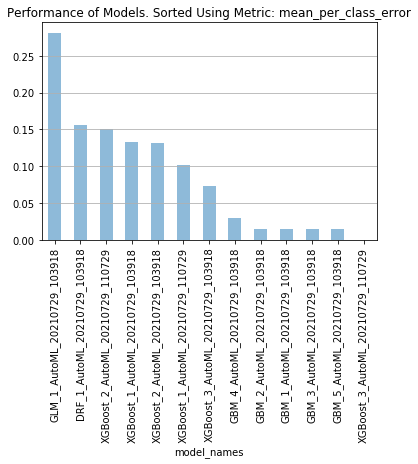

In [33]:
# ---- Uneditible ----
sort_metric = model_data["leaderboard"]["sort_metric"]
model_names = []
for model in model_data["leaderboard"]["models"]:
    model_names.append(model["name"])

model_metrics = model_data["leaderboard"]["sort_metrics"]

df = pd.DataFrame(
    {
        "model_names": model_names,
        "model_metrics": model_metrics
    }
)
df.sort_values("model_metrics", inplace=True, ascending=False)
ax = df.plot(y="model_metrics", x="model_names", kind="bar", align="center", alpha=0.5, legend=None)
plt.xticks(rotation=90)
ax.set_title("Performance of Models. Sorted Using Metric: {}".format(sort_metric))
ax.yaxis.grid(True)
# ---- Uneditible ----

**Save Model:**
___
Save model for prediction.
- **best_model_id:** Select model to save out. (By default selects the best model as determined by the selected performance metric.)

In [23]:
best_model_id = df.iloc[0]["model_names"]

In [42]:
# ---- Uneditible ----
h2o_name = best_model_id
zip_name = h2o_name + ".zip"
worker_h2o.download_model_mojo(auth, h2o_name)
high_level_mojo = worker_h2o.get_train_model(auth, h2o_name, "single")
model_to_save = high_level_mojo["models"][0]
model_to_save["model_identity"] = h2o_name
model_to_save["userid"] = "user"
model_to_save["timestamp"] = "time_stamp"
mts = prediction_engine.save_model(auth, model_to_save)
# ---- Uneditible ----

get /getModel?model_id=DRF_1_AutoML_20210728_014432&
post /saveModel


## View Model

**Variable Importance:**
___
View variable important of saved model.

In [45]:
# ---- Uneditible ----
prediction_engine.get_user_model(auth, h2o_name)
stats = worker_h2o.get_model_stats(auth, h2o_name, "ecosystem", "variable_importances")
var_names = []
for column in stats["columns"]:
    var_names.append(column["name"])
notebook_functions.RenderJSON(stats)
df = pd.DataFrame(
    {
        var_names[0]: stats["data"][0],
        var_names[1]: stats["data"][1],
        var_names[2]: stats["data"][2],
        var_names[3]: stats["data"][3]
    }
)
df
# ---- Uneditible ----

get /getUserModel?model_identity=DRF_1_AutoML_20210728_014432&
get /getModelStats?model_id=DRF_1_AutoML_20210728_014432&source=ecosystem&stats_type=variable_importances&


,variable,relative_importance,scaled_importance,percentage
0,age,247181.062500,1.000000,0.471352
1,education,166588.921875,0.673955,0.317670
2,marital,54350.242188,0.219880,0.103641
3,housing,39685.382812,0.160552,0.075676
4,loan,16603.177734,0.067170,0.031661


## Run Prediction

In [ ]:
attributes = [
    "mcc_base_category"="mcc_base_category",
    "account_type"="account_type",
    "eff_date_day_of_year"="eff_date_day_of_year",
    "education"="education",
    "changeIndicatorThree"="changeIndicatorThree",
    "trns_amt"="trns_amt",
    "changeIndicatorSix"="changeIndicatorSix",
    "language"="language",
    "effYearMonth"="effYearMonth",
    "mcc_category"="mcc_category",
    "eff_date_week_and_day"="eff_date_week_and_day",
    "eff_date_day"="eff_date_day",
    "mcc_spend_type"="mcc_spend_type",
    "mcc_category_tree"="mcc_category_tree",
    "eff_date_public_holiday"="eff_date_public_holiday",
    "eff_date_day_weekend"="eff_date_day_weekend",
    "proprtyOwnership"="proprtyOwnership",
    "intl_ind"="intl_ind",
    "numberOfAddresses"="numberOfAddresses",
    "numberOfChildren"="numberOfChildren",
    "mcc_description"="mcc_description",
    "eff_date_date"="eff_date_date",
    "eff_date_week_of_year"="eff_date_week_of_year",
    "region"="region",
    "mcc_sub_category"="mcc_sub_category",
    "maritalStatus"="maritalStatus",
    "eff_date"="eff_date",
    "trait_description"="trait_description",
    "gender"="gender",
    "trns_amt_category"="trns_amt_category",
    "eff_date_day_of_week"="eff_date_day_of_week",
    "trns_amt_base_category"="trns_amt_base_category",
    "eff_date_year_month"="eff_date_year_month",
    "trns_type"="trns_type",
    "eff_date_year"="eff_date_year",
    "eff_date_day_of_week_no"="eff_date_day_of_week_no",
    "segment_enum"="segment_enum",
    "trns_amt_spend_type"="trns_amt_spend_type",
    "trns_amt_category_tree"="trns_amt_category_tree",
    "trns_amt_sub_category"="trns_amt_sub_category",
    "personality_description"="personality_description",
    "numberOfProducts"="numberOfProducts",
    "MCC"="MCC",
    "eff_date_month"="eff_date_month",
    "trns_amt_description"="trns_amt_description",
    "eff_date_week_of_month"="eff_date_week_of_month",
    "effReformatted"="effReformatted",
    "age"="age",
    "customer"="customer"
]
database = "master"
collection = "bank_transactions"
search = "{}"
sort = "{}"
predictor = zip_name
predictor_label = "prediction"

In [ ]:
# ---- Uneditible ----
data_munging_engine.predicition_enrich(auth, database, collection, search, sort, predictor, predictor_label, attributes) 
# ---- Uneditible ----